In [1]:
# Code outline:
# 1. Indoor system - data:
#   a. Read data and parameters
#   b. process data (measurements)
# 2. Outdoor system - data:
#   a. Read data and parameters
#   b. Process data (measurements)
#   c. Build interpolations functions for temperature and light HOBO data
# 3. Offshore system - data:
#   a. Read data and parameters
#   b. Process data (measurements)
#   c. Build interpolations functions for temperature and light IMS data
# 4. Calculate model results for:
#   a. Indoor system
#   b. Outdoor system
#   c. Offshore system
# 5. Calculate errors in the combined df
# df_combined structure:
#System, time, m_exp, m_mod, m_SRE,Nint_exp, Nint_mod, Nint_SRE Next_exp, Next_mod, Next_SRE
# 6... minimize errors?

In [2]:
from __future__ import division
import numpy as np
import scipy as sp
from scipy.integrate import odeint
from scipy import stats
from scipy import interpolate
from scipy.integrate import solve_ivp
import math
import matplotlib.pyplot as plt
import pandas as pd # to read excel
print(f"pandas version is {pd.__version__}")
import seaborn as sns
from array import *
import researchpy as rp
import scipy.stats as stats
%matplotlib inline

from myfunctions import *

import datetime

pandas version is 1.0.1


In [3]:
# 1. Indoor system
#   a. Read data and parameters from excel file

xl = pd.ExcelFile('../data/Parameters.xlsx')
x2 = pd.ExcelFile('../data/Data.xlsx')

# Import parameters into df1
df1 = xl.parse('Parameters')

# assigmment of parameters to values: 
for key,val in zip(df1.Parameter,df1.Indoor_value):
    exec(key + '=val')
    print(key,val)

umol_to_percent_DW 0.0014
n_days 7.0
Duration 7.0
Nint0 1.85
m0 0.15
Nintcrit 4.5
miu 0.04
Nintmax 5.5
Nintmin 0.48
Ks 14.0
Vmax 60.0
Z 0.178
KI 35.0
K0 0.5
Ka 0.05
Topt 18.0
Tmin 5.0
Tmax 35.0
n 5.0
losses20 0.0016
teta 1.047
Sopt 25.0
Smin 3.0
Smax 48.0
Shigh 30.0
Slow 12.0
KN 1.1
dNextoutdt 0.014
dNextindt 0.0
dmoutdt 0.0
Next00  4032.0
dilution 0.0


In [4]:
#Re-calibrate after sample 80 is reanalysed 

In [5]:
# parameters for minimum combined error:
miu = 0.033 #0.04
losses20 = 0.003 # 0.004
Nintmax = 4.2 #4.25
Nintcrit = 3.9 #3.9 #3.5 
Ks = 15.5 #25.8 #15.5
Vmax = 199 #199 #150 #199
KI = 78 #15.2 - outdoor the irradiance is high?
K0 = 2.4 #2.1
Ka = 0.123 #0.12 #0.075
Smin = 7.75 #0 #2.5 #5
Sopt = 27 #28 #34
Smax = 44.2 #45
Topt = 20.6 #21.9 # 20.6
Tmax = 36.5 #35.9 # 36.5
n = 5.1
Tmin = 5

In [6]:
# parameters for minimum combined error - multiscale:
miu = 0.04 #0.046
losses20 = 0.004 #0.005
Nintmax = 4.5 #4.25
Nintcrit = 3.5 #2 #3.7
dNextoutdt = 0.008 #0 #0.04
Ks = 15.5 #25.8 #14 #24.8
Vmax = 60 #53 # low because of nitrate
KI = 16 #15.2 #18 #20 #139
K0 = 2.4 #1.5 #1.7
Ka = 0.12 #0.15 #0.127
Smin = 0 #2.5
Sopt = 28 #18
Smax = 45 #45
Topt = 18 #22.2  #21.9 #18
Tmax = 35.9 #34.4
n = 5.1 #2
Tmin = 4

In [7]:
X = [0.03812255859375,
 0.003099609375,
 4.12744140625,
 1.116259765625,
 0.013515136718750001,
 13.291015625,
 68.65234375,
 32.07275390625,
 1.690185546875,
 0.0499853515625,
 6.2646484375,
 21.396484375,
 49.1650390625,
 18.1494140625,
 33.6220703125,
 5.24560546875]

In [8]:
miu = X[0]
lossess20 = X[1]
Nintmax = X[2]
Nintcrit = X[3]
dNextoutdt = X[4]
Ks = X[5]
Vmax = X[6]
KI = X[7]
K0 = X[8]
Ka = X[9]
Smin = X[10]
Sopt = X[11]
Smax = X[12]
Topt = X[13]
Tmax = X[14]
n = X[15]

In [9]:
# 3. Offshore system - data:
#   a. Read data and parameters
# Import offshore data into df4
df4 = x2.parse('Offshore')

In [10]:
df4

,Sample,Exp,Period,Cage,Depth,Stage,Days,Timei,Timeh,Timem,...,Protein,Starch,NH4,NO3,dN,TN,DGR,Treatment,Comment,Comment 2
0,1.00,1,Continuous,1,1,i,NaN,"2019,5,20,09,0","2019,5,20,09,0","2019,5,20,09,0",...,NaN,NaN,0.105227,NaN,NaN,7.110000,NaN,NaN,NaN,NaN
1,2.00,1,Continuous,2,1,i,NaN,"2019,5,20,09,0","2019,5,20,09,0","2019,5,20,09,0",...,NaN,NaN,0.105227,NaN,NaN,7.110000,NaN,NaN,NaN,NaN
2,3.00,1,Continuous,3,1,i,NaN,"2019,5,20,09,0","2019,5,20,09,0","2019,5,20,09,0",...,NaN,NaN,0.105227,NaN,NaN,7.110000,NaN,NaN,NaN,NaN
3,4.00,1,Continuous,4,1,i,NaN,"2019,5,20,09,0","2019,5,20,09,0","2019,5,20,09,0",...,NaN,NaN,0.105227,NaN,NaN,7.110000,NaN,NaN,NaN,NaN
4,5.00,1,Continuous,5,1,i,NaN,"2019,5,20,09,0","2019,5,20,09,0","2019,5,20,09,0",...,NaN,NaN,0.105227,NaN,NaN,7.110000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,140.12,5,Continuous,20,5,f,NaN,"2020,04,30,11,0","2020,04,30,11,0","2020,05,8,0,0",...,NaN,NaN,NaN,NaN,0.256732,0.157342,0.185417,NaN,NaN,NaN
172,141.12,5,Continuous,21,5,f,NaN,"2020,04,30,11,0","2020,04,30,11,0","2020,05,8,0,0",...,NaN,NaN,NaN,NaN,NaN,NaN,0.172500,NaN,NaN,NaN
173,142.12,5,Continuous,22,5,f,NaN,"2020,04,30,11,0","2020,04,30,11,0","2020,05,8,0,0",...,NaN,NaN,NaN,NaN,NaN,NaN,0.150000,NaN,NaN,NaN
174,143.12,5,Continuous,23,5,f,NaN,"2020,04,30,11,0","2020,04,30,11,0","2020,05,8,0,0",...,NaN,NaN,NaN,NaN,0.466493,0.133223,0.177917,NaN,NaN,NaN


In [11]:
T = []
for i in df4['Sample'][:]:
    T1 = df4['Timeh'][df4['Sample'].values.tolist().index(i)]
    T2 = df4['Time'][df4['Sample'].values.tolist().index(i)]
    T.append(Time_to_Hours(T1,T2))
    
df4.loc[:,'T'] = T


df4f = df4[(df4.Stage == 'f')]
df4i = df4[(df4.Stage == 'i')]
# DWi = df3i.DW
# Ni = df3i.N
#df4f = df4f.assign(DWi = df3i.DW.values)
df4f = df4f.assign(Ni = df4i.N.values)

df4Reduced = df4f[(df4f.Stage == 'f') & (df4f.Depth == 5) & (df4f.Exp != 1) & (df4f.Period == 'Continuous')]
df4Reduced

,Sample,Exp,Period,Cage,Depth,Stage,Days,Timei,Timeh,Timem,...,NH4,NO3,dN,TN,DGR,Treatment,Comment,Comment 2,T,Ni
62,53.70,2,Continuous,13,5,f,NaN,"2019,7,22,11,0","2019,7,22,11,0","2019,7,22,11,0",...,0.396883,NaN,NaN,NaN,0.077470,1000 / 7 / 18,fertilization in a 35 liter container,NaN,170,1.760000
63,54.70,2,Continuous,14,5,f,NaN,"2019,7,22,11,0","2019,7,22,11,0","2019,7,22,11,0",...,0.396883,NaN,NaN,NaN,0.177315,1000 / 7 / 18,fertilization in a 35 liter container,NaN,170,NaN
64,55.70,2,Continuous,15,5,f,NaN,"2019,7,22,11,0","2019,7,22,11,0","2019,7,22,11,0",...,0.396883,NaN,0.857715,0.063476,0.192143,1000 / 7 / 18,fertilization in a 35 liter container,NaN,170,NaN
65,56.70,2,Continuous,16,5,f,NaN,"2019,7,22,11,0","2019,7,22,11,0","2019,7,22,11,0",...,0.396883,NaN,NaN,NaN,0.124470,NaN,NaN,NaN,170,NaN
66,57.70,2,Continuous,17,5,f,NaN,"2019,7,22,11,0","2019,7,22,11,0","2019,7,22,11,0",...,0.396883,NaN,NaN,NaN,0.129353,NaN,NaN,NaN,170,NaN
67,58.70,2,Continuous,18,5,f,NaN,"2019,7,22,11,0","2019,7,22,11,0","2019,7,22,11,0",...,0.396883,NaN,0.997686,0.039678,0.106246,NaN,NaN,NaN,170,NaN
119,93.70,3,Continuous,13,5,f,NaN,"2019,10,30,13,0","2019,10,30,13,0","2019,10,30,13,0",...,1.451602,NaN,0.020445,0.052255,0.069286,NaN,NaN,NaN,166,1.193394
120,94.70,3,Continuous,14,5,f,NaN,"2019,10,30,13,0","2019,10,30,13,0","2019,10,30,13,0",...,1.451602,NaN,NaN,NaN,0.082143,NaN,NaN,NaN,166,NaN
121,95.70,3,Continuous,15,5,f,NaN,"2019,10,30,13,0","2019,10,30,13,0","2019,10,30,13,0",...,1.451602,NaN,NaN,NaN,0.082143,NaN,NaN,NaN,166,NaN
122,96.70,3,Continuous,16,5,f,NaN,"2019,10,30,13,0","2019,10,30,13,0","2019,10,30,13,0",...,1.451602,NaN,NaN,NaN,0.067143,NaN,NaN,NaN,166,NaN


In [12]:
# c. Build interpolations functions for temperature data

xCTD = pd.ExcelFile('../data/CTDr.xlsx')
dfCTD = xCTD.parse('HaderaCTD',header=None)

dfCTD

,0,1,2,3,4,5,6,7,8,9,10
0,time_ISO8601 [yyyy-mm-ddThh:mm:ss:sss],Year,Month,Day,Time,Date&Time,WaterTemp [degC],Depth [m],Longitude [degrees_east],Latitude [degrees_north,Bot. Depth [m]
1,2019-07-22T00:01:03,2019,07,22,00:01:03,2019-07-22 00:01:03,29.7534,12,1,NaN,NaN
2,2019-07-22T00:11:04,2019,07,22,00:11:04,2019-07-22 00:11:04,29.6921,12,2,NaN,NaN
3,2019-07-22T00:21:03,2019,07,22,00:21:03,2019-07-22 00:21:03,29.7344,12,3,NaN,NaN
4,2019-07-22T00:31:04,2019,07,22,00:31:04,2019-07-22 00:31:04,29.6629,12,4,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
42620,2020-05-12T23:11:03,2020,05,12,23:11:03,2020-05-12 23:11:03,21.6181,12,140,NaN,NaN
42621,2020-05-12T23:21:04,2020,05,12,23:21:04,2020-05-12 23:21:04,21.6203,12,141,NaN,NaN
42622,2020-05-12T23:31:03,2020,05,12,23:31:03,2020-05-12 23:31:03,21.576,12,142,NaN,NaN
42623,2020-05-12T23:41:04,2020,05,12,23:41:04,2020-05-12 23:41:04,21.6585,12,143,NaN,NaN


In [13]:
# Import water temperature data

Twater = dfCTD.iloc[1:42624:1][6].values 

# TCTD = dfCTD.iloc[1:42624:1][6]
# Twater = []
# for i in TCTD:
#     #if type(i) == int:
#     #    i = str(i)
#     Twater.append(i)#float(re.sub(r"\s+", "", i, flags=re.UNICODE)))

In [14]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [15]:
# T_average is a moving average of 1 hour with jumps of 1 hours (6 times 10 minutes)

T_average = moving_average(Twater[::6],6)


In [16]:
#plt.plot(moving_average(Twater[1::6],6),'r',alpha=.3)
#plt.plot(T_average,'b',alpha=.2)

In [17]:
# c. Build interpolations functions for temperature and light IMS data
    # 1. Import combined IMS excel for light function
dfims = pd.read_csv('../data/ims.csv',encoding= 'unicode_escape',header=None)
# days = list(range(1,296))
days = np.arange(1,296) # or from day 0? np.arange(296)

I_plot = np.zeros(24*296)
light_hours = np.arange(5,19)
for day in days:
    for hour in light_hours:
        I_plot[(day-1)*24 + hour] = float(dfims.iloc[day][hour-1])


all_hours = np.arange(1,296*24+1)

fI0 = interpolate.interp1d(all_hours, I_plot,kind = 'linear',bounds_error=False, fill_value="extrapolate")

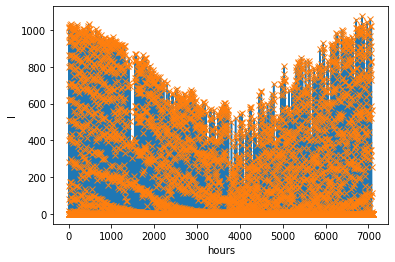

In [18]:
plt.plot(all_hours,fI0(all_hours),all_hours,I_plot,'x')
plt.xlabel('hours')
plt.ylabel('I');

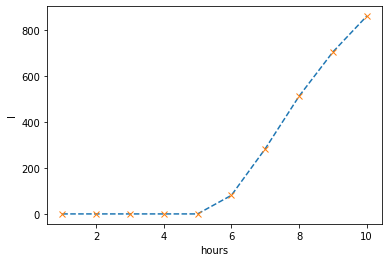

In [19]:
plt.plot(all_hours[:10],fI0(all_hours[:10]),'--',all_hours[:10],I_plot[:10],'x')
plt.xlabel('hours')
plt.ylabel('I');

In [20]:
# 4. Calculate model results for:

In [21]:
df4Reduced

,Sample,Exp,Period,Cage,Depth,Stage,Days,Timei,Timeh,Timem,...,NH4,NO3,dN,TN,DGR,Treatment,Comment,Comment 2,T,Ni
62,53.70,2,Continuous,13,5,f,NaN,"2019,7,22,11,0","2019,7,22,11,0","2019,7,22,11,0",...,0.396883,NaN,NaN,NaN,0.077470,1000 / 7 / 18,fertilization in a 35 liter container,NaN,170,1.760000
63,54.70,2,Continuous,14,5,f,NaN,"2019,7,22,11,0","2019,7,22,11,0","2019,7,22,11,0",...,0.396883,NaN,NaN,NaN,0.177315,1000 / 7 / 18,fertilization in a 35 liter container,NaN,170,NaN
64,55.70,2,Continuous,15,5,f,NaN,"2019,7,22,11,0","2019,7,22,11,0","2019,7,22,11,0",...,0.396883,NaN,0.857715,0.063476,0.192143,1000 / 7 / 18,fertilization in a 35 liter container,NaN,170,NaN
65,56.70,2,Continuous,16,5,f,NaN,"2019,7,22,11,0","2019,7,22,11,0","2019,7,22,11,0",...,0.396883,NaN,NaN,NaN,0.124470,NaN,NaN,NaN,170,NaN
66,57.70,2,Continuous,17,5,f,NaN,"2019,7,22,11,0","2019,7,22,11,0","2019,7,22,11,0",...,0.396883,NaN,NaN,NaN,0.129353,NaN,NaN,NaN,170,NaN
67,58.70,2,Continuous,18,5,f,NaN,"2019,7,22,11,0","2019,7,22,11,0","2019,7,22,11,0",...,0.396883,NaN,0.997686,0.039678,0.106246,NaN,NaN,NaN,170,NaN
119,93.70,3,Continuous,13,5,f,NaN,"2019,10,30,13,0","2019,10,30,13,0","2019,10,30,13,0",...,1.451602,NaN,0.020445,0.052255,0.069286,NaN,NaN,NaN,166,1.193394
120,94.70,3,Continuous,14,5,f,NaN,"2019,10,30,13,0","2019,10,30,13,0","2019,10,30,13,0",...,1.451602,NaN,NaN,NaN,0.082143,NaN,NaN,NaN,166,NaN
121,95.70,3,Continuous,15,5,f,NaN,"2019,10,30,13,0","2019,10,30,13,0","2019,10,30,13,0",...,1.451602,NaN,NaN,NaN,0.082143,NaN,NaN,NaN,166,NaN
122,96.70,3,Continuous,16,5,f,NaN,"2019,10,30,13,0","2019,10,30,13,0","2019,10,30,13,0",...,1.451602,NaN,NaN,NaN,0.067143,NaN,NaN,NaN,166,NaN



Experiment: #2

Initial Nint is: 1.76
Initial biomass: 2.083
Modeled biomass for Exp 2: 3.015
Modeled Nint for Exp 2: 0.713
Modeled Next: 0.5


Sample: #53
Measured biomass: 3.229
Measured Nint: nan

The Sqaure Relative Error for biomass is: 0.005
The Sqaure Relative Error for Nint is: nan

Sample: #54
Measured biomass: 4.646
Measured Nint: nan

The Sqaure Relative Error for biomass is: 0.292
The Sqaure Relative Error for Nint is: nan

Sample: #55
Measured biomass: 4.885
Measured Nint: 0.902

The Sqaure Relative Error for biomass is: 0.385
The Sqaure Relative Error for Nint is: 0.071

Sample: #56
Measured biomass: 3.937
Measured Nint: nan

The Sqaure Relative Error for biomass is: 0.094
The Sqaure Relative Error for Nint is: nan

Sample: #57
Measured biomass: 3.99
Measured Nint: nan

The Sqaure Relative Error for biomass is: 0.104
The Sqaure Relative Error for Nint is: nan

Sample: #58
Measured biomass: 3.615
Measured Nint: 0.762

The Sqaure Relative Error for biomass is: 0.039
The Sq

TypeError: 'numpy.float64' object is not iterable

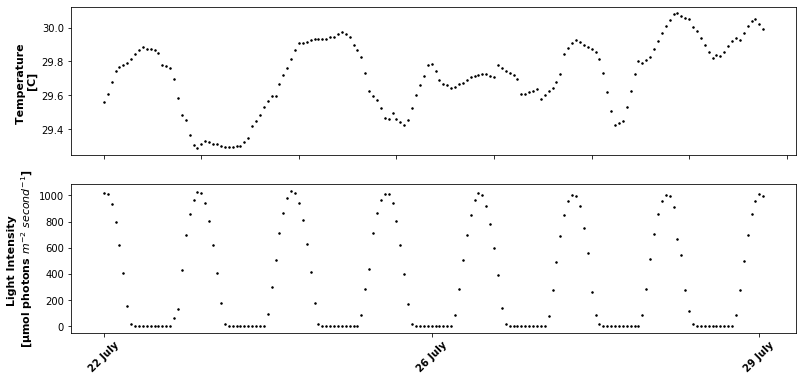

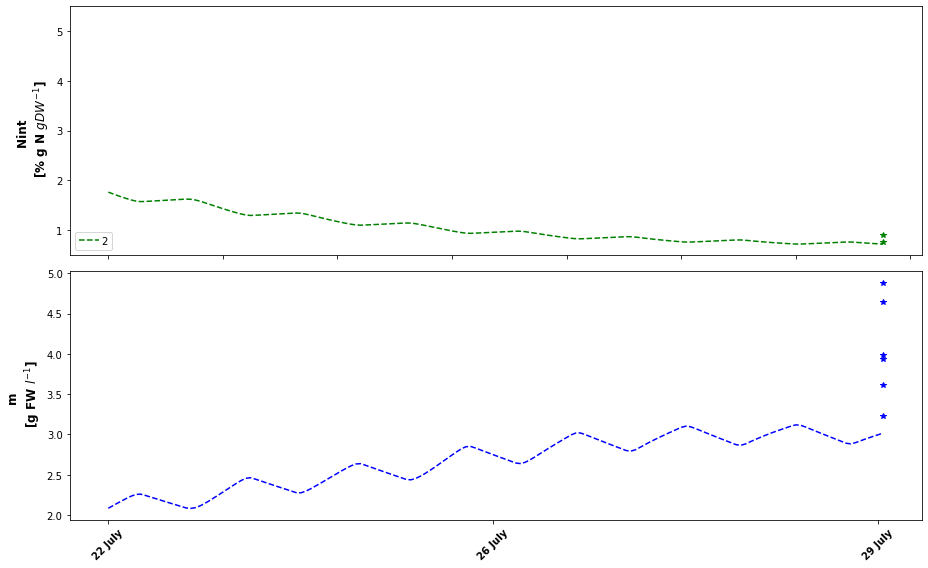

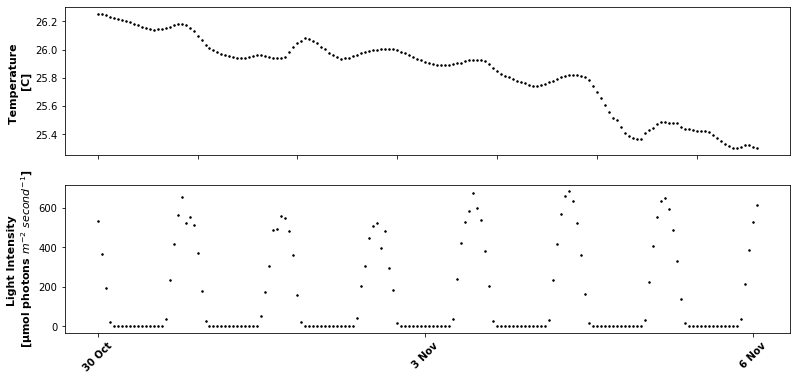

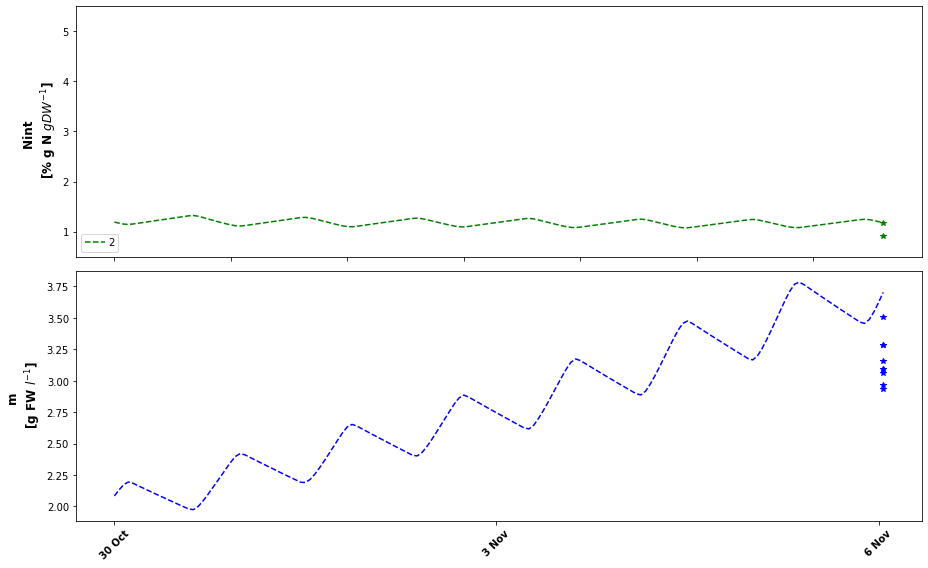

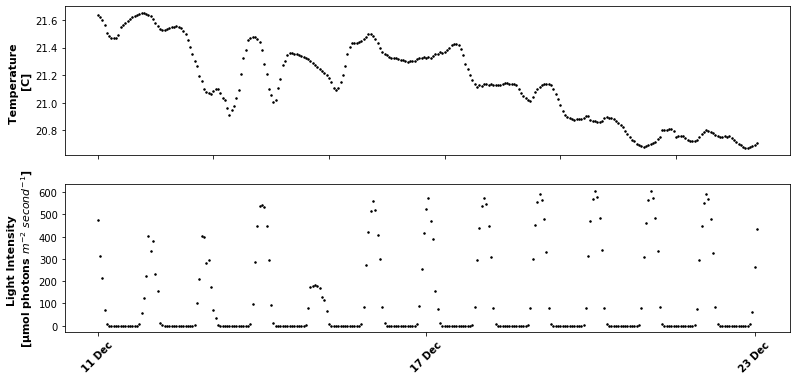

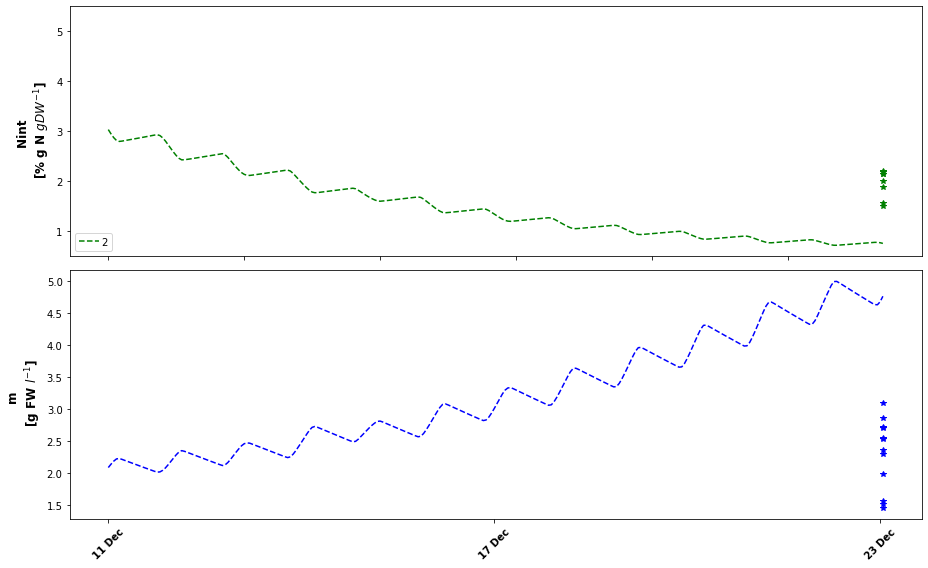

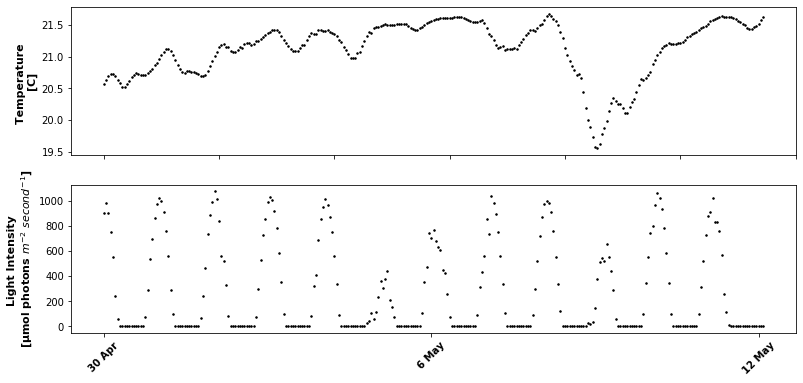

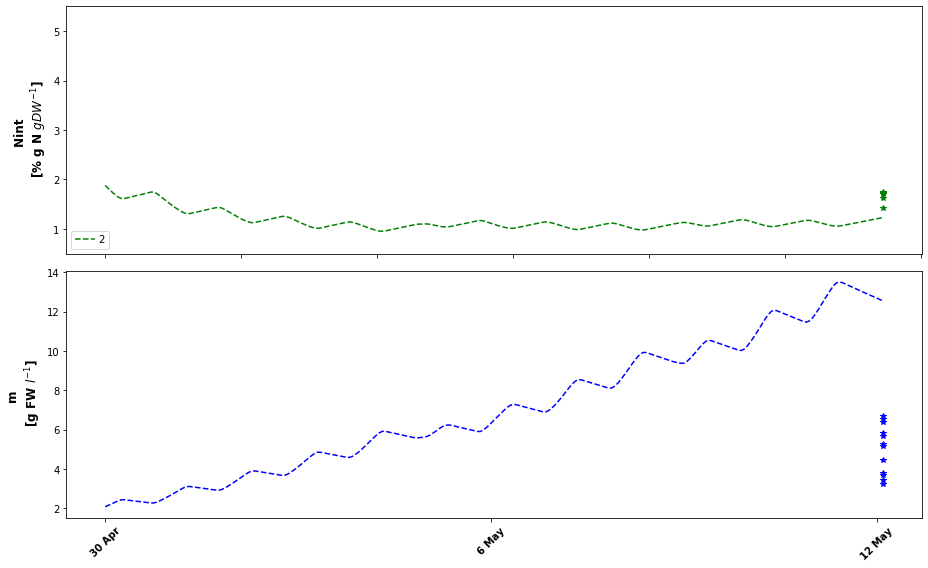

In [22]:
#Ka = 0.15
mmod_all,mSRE3Exp,Nintmod_all,NintSRE3Exp = [],[],[],[]
mSRE3, NintSRE3 = [], []
mmodAll, mSRE3All, NintmodAll, NintSRE3All = [],[],[],[]

Experiments = [2,3,4,5]
xlabels_all = [['22 July','26 July', '29 July'],['30 Oct','3 Nov', '6 Nov'],['11 Dec','17 Dec', '23 Dec'],['30 Apr', '6 May','12 May'],]


Next_0_all = [0.5,2,0.5,2]
m_0 = (20 / 1.44) * 0.15
Nint_0_all = [1.76, 1.19, 3.03, 1.88]
VA = 1.44 / (0.3 * 0.15) # units: [g DW/ m^2] # A = w*l - conversion from volumetric to areal units
Z = 5 # m - depth of cages in water
for i in Experiments:
    DATA = []
    xlabels = xlabels_all[i-2]
    print('\nExperiment: #' + str(i) + '\n')

    df4Temp = df4Reduced[(df4Reduced.Exp == i)] 
    Samples = df4Temp.Sample.values
    Nint_0 = Nint_0_all[i-2]
    Next_0 = Next_0_all[i-2]
    
    t = np.arange(df4Temp['T'].values[0])
    T1 = '2019,07,22,0,0'
    T2 = df4Temp['Timei']
    T2 = T2.tolist()[0]
    t0 = Time_to_Hours(T1,T2)

    # light function
    I_reduced = I_plot[t0:t0+t[-1]+1]
    #print(I_reduced)
    fI0 = interpolate.interp1d(t, I_reduced,kind = 'linear', bounds_error=False, fill_value="extrapolate")
    
    # T function
    T_reduced = T_average[t0:t0+t[-1]+1] 
    #print(T_reduced)

    fTemp0 = interpolate.interp1d(t, T_reduced,kind = 'linear', bounds_error=False, fill_value="extrapolate")
    
    NEXT, NINT, M, TT = [],[],[],[]
    x0 = [Next_0,Nint_0,m_0]  
    
    # model simulation

    # setup initial conditions

    x = odeint(Offshore_constant_N_new,x0,t,args=(Nintmax,Nintmin,Vmax,Ks,dNextoutdt,dNextindt,miu,dmoutdt,Nintcrit,Sopt,Z,KI,K0,Ka,
                                           Topt,Tmin,Tmax,losses20,teta,Sopt,Smin,Smax,n,umol_to_percent_DW,fTemp0,fI0,VA))
        
    NEXT.append(x[: , 0]) #
    NINT.append(x[: , 1]) #
    M.append(x[: , 2])    #
    TT.append(t)

    t_model = np.hstack(TT)
    Next_model = np.hstack(NEXT)
    Nint_model = np.hstack(NINT)
    m_model = np.hstack(M)
    
    
    mmod_all.append(m_model[-1])
    print('Initial Nint is: ' + str(round(Nint_0,3)))
    print('Initial biomass: ' + str(round(m_0,3)))
    print('Modeled biomass for Exp ' + str(i) + ': ' + str(round(float(mmod_all[-1]),3)))
    Nintmod_all.append(Nint_model[-1])
    print('Modeled Nint for Exp ' + str(i) + ': ' + str(round(float(Nintmod_all[-1]),3)))
    print('Modeled Next: ' + str(round(float(Next_model[-1]),3)) + '\n')
    
    # plot I and T
    fig2, ax2 = plt.subplots(2,1,figsize=(13,6))
    ax2[0].plot(t,T_reduced,'.',markersize=3,color='black')
    ax2[1].plot(t,I_reduced,'.',markersize=3,color='k')

    ax2[0].set_ylabel('Temperature \n[C]',fontsize=11, weight="bold")
    ax2[1].set_ylabel('Light Intensity \n[µmol photons $m^{-2}$ $second^{-1}$]',fontsize=11, weight="bold")

    ax2[0].set_xticklabels([])
    ax2[1].set_xticklabels([])
    ax2[1].set_xticks(t[0:len(t):int(len(t)/2-1)])
    ax2[1].set_xticklabels([str(i) for i in xlabels], rotation=45,fontsize=10, weight="bold")
    
    # plot model
    fig, ax = plt.subplots(2,1,figsize=(13,8))
    ax[0].plot(t,NINT[-1],linestyle = '--',markersize=3.5,color='green')
    ax[0].set_ylim([0.5,5.5])
    ax[1].plot(t,M[-1],linestyle = '--',markersize=3.5,color='blue')

    #col = len(l)
    ax[0].legend(Experiments,loc='lower left',fontsize='medium',markerscale=2,columnspacing = 0.2,handletextpad = 0.3)#,edgecolor='white')
        
    mexp_Temp,Nintexp_Temp = [],[]
    for j in Samples:
        
        print('\nSample: #' + str(math.floor(j)))
        mexp = df4Temp[df4Temp.Sample == j].DW
        mexp = mexp.tolist()[0]
        mexp_Temp.append(mexp)
        Nintexp = df4Temp[df4Temp.Sample == j].N
        Nintexp = Nintexp.tolist()[0]
        Nintexp_Temp.append(Nintexp)
        print('Measured biomass: ' + str(round(mexp,3)))
        print('Measured Nint: ' + str(round(Nintexp,3)) + "\n")      
        
        mSRE3Exp.append(((mexp-mmod_all[-1])/mmod_all[-1])**2)
        mSRE3All.append(((mexp-mmod_all[-1])/mmod_all[-1])**2)
        NintSRE3Exp.append(((Nintexp-Nintmod_all[-1])/Nintmod_all[-1])**2)   
        NintSRE3All.append(((Nintexp-Nintmod_all[-1])/Nintmod_all[-1])**2)   
        print('The Sqaure Relative Error for biomass is: ' + str(round(mSRE3Exp[-1],3)))
        print('The Sqaure Relative Error for Nint is: ' + str(round(NintSRE3Exp[-1],3)))
        ax[1].plot(t[-1],mexp,'*',markersize = 6,color='blue')
        ax[0].plot(t[-1],Nintexp,'*',markersize = 6,color='green')

    
    data = {'T':T[0],'Next':NEXT[0],'Nint':NINT[0],'m':M[0]}
    DATA.append(data)
    #ax[1].plot(t[-1],mexp_Temp[k-1][j],'*',markersize = 6,color=color)
    #ax[0].plot(t[-1],Nintexp_Temp[k-1][j],'*',markersize = 6,color=color)
    
    ax[0].set_xticklabels([])
    ax[1].set_xticklabels([])
    ax[1].set_xticks(t[0:len(t):int(len(t)/2-1)])
    ax[1].set_xticklabels([str(i) for i in xlabels], rotation=45,fontsize=10, weight="bold")

    ax[0].set_ylabel('Nint \n [% g N $g DW^{-1}$]',fontsize=12, weight="bold")
    ax[1].set_ylabel('m \n [g FW $l^{-1}$]',fontsize=12, weight="bold")

    plt.tight_layout()
    
#mSRE3All.append(mSRE3Exp)
#NintSRE3All.append(NintSRE3Exp)
#mSRE3Exp,NintSRE3Exp = [],[]
    

RMSREm3 = round((np.mean(mSRE3All))**0.5,3)
cleanedNintSRE3 = [x for x in NintSRE3All[0] if str(x) != 'nan']
#print(cleanedNintSRE3)
RMSRENint3 = round((np.mean(cleanedNintSRE3))**0.5,3)


#RMSRENint2 = round((np.mean(cleanedNintSRE2))**0.5,3)
print('\nThe RMSRE of m in the offshore system is: ' + str(RMSREm3))
print('The RMSRE of Nint in the offshore system is: ' + str(RMSRENint3))

In [ ]:
#   c. Offshore system
    # I. Produce an array ("m/Nint_mod") of all model results for final m value (depends time, light, T and more) - done by runing the model in a loop
    # *requires model function wit constant Next
    # II. Add relevant columns from df3_temp and the model results to a new df_combined

In [ ]:
# 5. Calculate SRE for m, Nint and Next in DF_combined

In [ ]:
# Biomass model error of calibration data

print(RMSREm3)
#0.42
#0.394

In [ ]:
# Biomass model error of calibration data

print(RMSRENint3)
#0.258
#0.198